# Hyperspectral Image classification using Random Forest
This exercise is meant to perform a pixel-wise classification on a 4 band Planet image using Decision Trees and Random Forest. The image has been acquired over a region in the Flevoland province of the Netherlands.

Version: 1

Last modified: 08 Oct 2019

This code is developed for educational purpose, to be used in Module "Advanced Image Analysis" at ITC.

The code is developed by Anurag Kulshrestha, with documentation help from Mr. John Ray Bergado.

The code is optimized for clarity rather than for computational efficiency.

Do not remove this announcement.

The code is distributed "as is", WITH NO WARRANTY whatsoever!

<h4>0.1: Installing Python</h4>

If Python is not yet installed, we suggest you install Anaconda 3. This is a python distribution package with a wide collection of additional packages. Furthermore, it allows for easy installation of Tensorflow and Keras through 'pip'. You can download the Anaconda 3 64-bit installer for Windows [here](https://repo.anaconda.com/archive/Anaconda3-2019.07-Windows-x86_64.exe). Execute the installer and wait for it to finish the installation (this might take a few minutes, perhaps grab a cup of cofee or tea).


<h4>0.2: Creating Anaconda environment</h4>

```
C:> conda create -n rforest python=3.6
```

to create an Anaconda environment where you will install all the necessary Python packages. An environment allows you to install several versions of a package independently (in a self-contained manner avoiding conflicting versions). Followed by a command activating the environment:

```
C:> activate rforest
(rforest)C:>  # Your prompt should change 
```

which you should always do so that you can use the packages you will be installing in this environment.

<h4>0.3: Installing gdal, rasterio and sklearn</h4>

Aside from the other python packages required in installing Tensorflow and Keras (such as numpy, scipy, etc), we need to install the gdal library, matplotlib, h5py, scikit-image, and scikit-learn. To install gdal, issue the command:

```
(rforest)C:> conda install gdal 
```

To install the other miscallaneous packages issue the command:

```
(rforest)C:> conda install rpy2 rasterio matplotlib scikit-image scikit-learn pydot
```

And finally, to view this notebook you need to install jupyter by issuing the command:

```
(rforest)C:> pip install jupyter
```

<h4>0.4: Testing the installation</h4>

If you have installed all the packages, you can test if all the installations were successful by trying to import all these packages. You can do this by:

```
(rforest)C:> python
>>> import gdal, matplotlib, skimage, sklearn, rpy2
```

If the import have not raised any error, the installation should have been successful. You can now then quit the python interactive console by:

```
>>> quit()
```

You should get back to the Anaconda environment and should change to the directory where you placed this notebook by:

```
(rforest)C:> cd ''directory where this notebook is''
(rforest)C:''directory where this notebook is''> jupyter notebook
```

A tab in your default web browser should open listing with graphical interface listing the files in the directory where this notebook is. Click this notebook to run it, a new tab in the browser should open this notebook.

### Importing the libraries

In [1]:
import gdal
import os
import scipy.io
import numpy as np
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Reading the data

In [2]:
dir = '/home/anurag/Documents/Teaching/AdvancedImageAnalysis/advanced image analysis_2017/3-Exercises/SVM_Hyper/Hyperspectral_data_and_code'
os.chdir(dir)
pandas2ri.activate()
PaviaU = scipy.io.loadmat('PaviaU.mat')['paviaU']
PaviaU_gt = scipy.io.loadmat('PaviaU_gt.mat')['paviaU_gt']
df=robjects.r['load']("PaviaU.R")

GT=robjects.r['GT']
ind=robjects.r['ind']
a=robjects.r['a'][0]
b=robjects.r['b'][0]

#Deliniate training and test data
#print(GT[ind])
TR = GT.values[ind]
TS = GT.values[-ind]

### Display the image

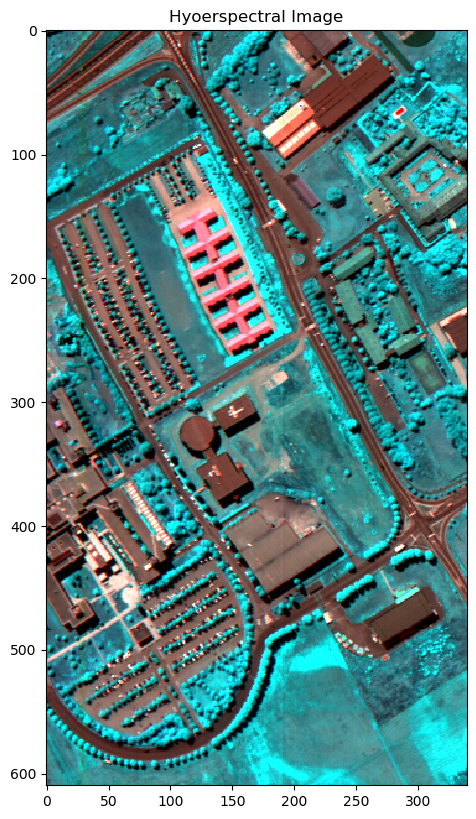

In [3]:
def hist_stretch_all(arr, bits, clip_extremes):
    n=arr.shape
    per=np.percentile(arr,[2.5, 97.5])
    per_max=per[1]
    per_min=per[0]
    min_arr=np.full(n, per_min)
    max_arr=np.full(n, per_max)
    if(clip_extremes==False):
        new_arr=arr
    else:
        new_arr=np.maximum(min_arr, np.minimum(max_arr, arr))
    if(bits==0):
        min_=np.amin(new_arr)
        max_=np.amax(new_arr)
        new_arr=(new_arr-min_)/(max_-min_)
    else:
        new_arr=np.floor((2**bits-1)*(new_arr-per_min)/(per_max-per_min))
    return new_arr

def display(arr, img_gt, cmap, x_label, y_label, title, num_ticks=5, colorbar=True):
    figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
    imgplot=plt.imshow(arr, cmap=cmap)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if colorbar:
        plt.colorbar()
    plt.show()

def plot_image(img_arr, img_gt, rgb_bands, clip_extremes=False):
    r=hist_stretch_all(img_arr[...,rgb_bands[0]], 0, clip_extremes)
    b=hist_stretch_all(img_arr[...,rgb_bands[2]], 0, clip_extremes)
    g=hist_stretch_all(img_arr[...,rgb_bands[1]], 0, clip_extremes)
    img = np.dstack((r,g,b))
    display(img, img_gt, None, '', '', 'Hyoerspectral Image', colorbar=False)

    
rgb_bands = 20,80,100
    
Image=(PaviaU-a)/(b-a) # normalization as for the Ground Truth
Image_gt=PaviaU_gt
#del(PaviaU)
#del(PaviaU_gt)   
plot_image(Image,0,rgb_bands,clip_extremes=True)
#Image.shape # check and interpret the output

In [4]:
def random_forest_classifier(features, target, options):
    """
    To train the random forest classifier with features and target data
    :param features:
    :param target:
    :return: trained random forest classifier
    """
    if options:
        clf = RandomForestClassifier(**options)
        #print('options lag gaye')
    else:
        clf = RandomForestClassifier()
    clf.fit(features, target)
    return clf

def decision_tree_classifier(features, target, options=None):
    """
    To train the decision_tree_classifier with features and target data
    :param features:
    :param target:
    :return: trained decision_tree_classifier
    """
    if options:
        clf = tree.DecisionTreeClassifier(**options)
        #print('options lag gaye')
    else:
        clf = tree.DecisionTreeClassifier()
    clf.fit(features, target)
    return clf

In [5]:
#Let us now define the randomForestClassifier. Define the parameters here.
rand_forest_options=dict(
    n_estimators=200,
    criterion='gini',
    max_depth=None,
    min_samples_split=2, #changed from 2
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=True,
    n_jobs=8,
    random_state=None, verbose=0, warm_start=False, class_weight=None
    )

In [6]:
train_x, train_y, test_x, test_y = TR[:,:-1], TR[:,-1],TS[:,:-1], TS[:,-1]

In [7]:
trained_model = random_forest_classifier(train_x, train_y, options=rand_forest_options)

#trained_model = decision_tree_classifier(train_x, train_y, options=dict(min_samples_split=10,max_depth=None))

In [8]:
predictions = trained_model.predict(test_x)

#for i in range(0, 5):
    #print ("Actual outcome :: {} and Predicted outcome :: {}".format(list(test_y)[i], predictions[i]))

# Train and Test Accuracy
print ("Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x)))
print ("Test Accuracy  :: ", accuracy_score(test_y, predictions))

print (" Confusion matrix \n", confusion_matrix(test_y, predictions))

Train Accuracy ::  1.0
Test Accuracy  ::  0.881
 Confusion matrix 
 [[283   1   5   0   1   1   5  14   0]
 [  0 827   0   8   0  11   0   1   0]
 [  4   0  56   0   0   1   0  31   0]
 [  0  22   0 141   0   2   0   0   0]
 [  0   0   0   0  63   0   0   2   0]
 [  1  86   0   0   1 136   0   3   0]
 [ 16   0   1   0   0   0  55   0   0]
 [  6   0  12   0   0   3   0 156   0]
 [  0   0   0   0   0   0   0   0  45]]


In [9]:
shp=Image.shape
predictions_image = trained_model.predict(Image.reshape(shp[0]*shp[1],shp[2]))

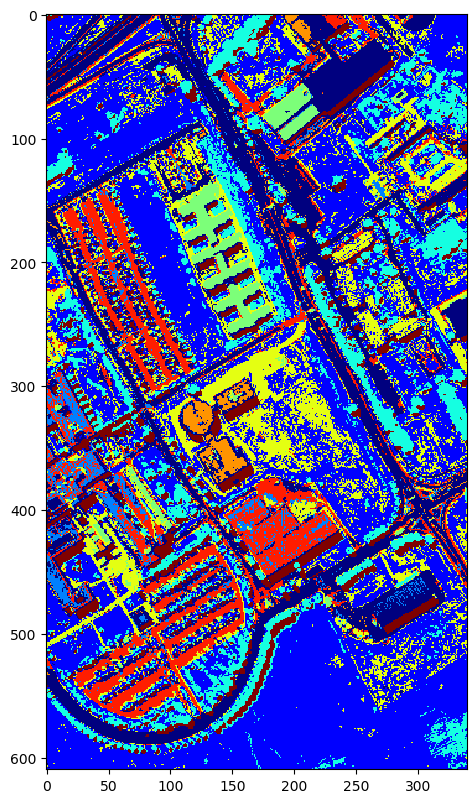

In [10]:
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(predictions_image.reshape(*shp[:2]), cmap='jet')
#plt.colorbar()
plt.show()

[0.00485149 0.00581825 0.0054124  0.00505541 0.01192476 0.00963798
 0.01134676 0.02038434 0.01121044 0.01472356 0.01902505 0.02042415
 0.02567958 0.02083351 0.02139497 0.02004993 0.01867331 0.01389212
 0.00911202 0.0102714  0.00808311 0.00846088 0.00789974 0.00749221
 0.0135289  0.00716985 0.00798824 0.00629649 0.00611016 0.00681512
 0.00615869 0.00743769 0.00651008 0.00511956 0.00691188 0.00873868
 0.00912149 0.00905372 0.00787573 0.00667374 0.00764146 0.0062257
 0.00646218 0.00855056 0.00574791 0.00431433 0.00382367 0.00493016
 0.0045566  0.00343812 0.00333194 0.00365142 0.00328794 0.00334764
 0.0032184  0.00423886 0.00362623 0.00364649 0.00553573 0.0059337
 0.00533971 0.00575804 0.00520346 0.00445498 0.00514036 0.00364036
 0.01036477 0.01155123 0.01518736 0.01268881 0.00780481 0.00518004
 0.00543251 0.00515168 0.00476813 0.00788888 0.00532262 0.00577574
 0.00596545 0.0051062  0.00826954 0.00828104 0.01507324 0.0071185
 0.01779215 0.01588409 0.01324266 0.01012689 0.01051795 0.0125494

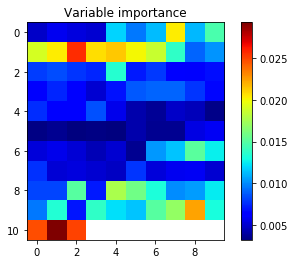

In [11]:
f_imp = trained_model.feature_importances_
print(f_imp)

plt.imshow(np.array(np.append(f_imp,np.repeat(np.nan,7)).reshape(11,10)), cmap='jet')
plt.colorbar()
plt.title('Variable importance')
plt.show()

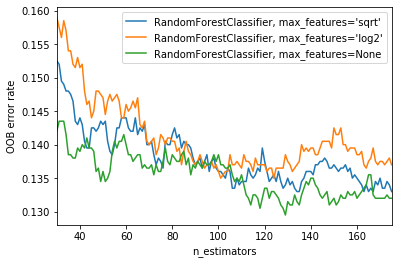

In [13]:
def get_oobscore(X,y):
    ensemble_clfs = [
        ("RandomForestClassifier, max_features='sqrt'",
            RandomForestClassifier(n_estimators=100,
                                   warm_start=True, oob_score=True,
                                   max_features="sqrt",
                                   random_state=RANDOM_STATE,n_jobs=4)),
        ("RandomForestClassifier, max_features='log2'",
            RandomForestClassifier(n_estimators=100,
                                   warm_start=True, max_features='log2',
                                   oob_score=True,
                                   random_state=RANDOM_STATE,n_jobs=4)),
        ("RandomForestClassifier, max_features=None",
            RandomForestClassifier(n_estimators=100,
                                   warm_start=True, max_features=None,
                                   oob_score=True,
                                   random_state=RANDOM_STATE,n_jobs=4))
    ]

    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    # Range of `n_estimators` values to explore.
    min_estimators = 30
    max_estimators = 175

    for label, clf in ensemble_clfs:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(X, y)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))

    # Generate the "OOB error rate" vs. "n_estimators" plot.
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()

from collections import OrderedDict  
RANDOM_STATE = None #123
get_oobscore(train_x, train_y)